# Emotion Classifier using Twitter data


In [1]:
# !pip install textblob
# !pip install nltk
# !pip install matplotlib
# !pip install scikit-learn
# !pip install xgboost
# !pip install pandas
# !pip install numpy


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import (
    model_selection,
    preprocessing,
    linear_model,
    naive_bayes,
    metrics,
    svm,
)
from sklearn import decomposition, ensemble
import re
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


## Reading file


In [2]:
data = pd.read_csv("sentiment-emotion-labelled_Dell_tweets.csv").dropna()
# data.drop('selected_text', axis=1,inplace=True)
data.drop("Unnamed: 0", axis=1, inplace=True)
data.head()


,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124


In [3]:
selected_columns = ["Text", "emotion"]
data = data[selected_columns]
data.head()


,Text,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",joy
3,@dell your customer service is horrible especi...,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,anger


### The data contains 4 columns. i only need the feeling and the tweets


In [4]:
data.dropna()
data.head()


,Text,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",joy
3,@dell your customer service is horrible especi...,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,anger


### the data has some tags with "@" and "#" symbols and numbers for the user names which i don't need for the emotion so i will take out


In [5]:
import spacy

nlp = spacy.load("en_core_web_lg")
# tweet_data.dtypes


/home/mojo/anaconda3/envs/nlp-project/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mojo/anaconda3/envs/nlp-project/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mojo/anaconda3/envs/nlp-project/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mojo/anaconda3/envs/nlp-project

## Preprocessing


In [6]:
def preprocess(sents):
    doc = nlp(sents)

    cleaned_text = [
        # performing lemmatization and removing punctuations, stop words, emails and urls from the text
        token.lemma_
        for token in doc
        if not (
            token.text.isdigit()
            or token.is_punct
            or token.is_stop
            or token.like_email
            or token.text.startswith("@")
            or token.text.startswith("#")
            or token.like_url
            or token.text.isspace()
        )
    ]

    return " ".join(cleaned_text)  # returns the cleaned text


data.head()


,Text,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",joy
3,@dell your customer service is horrible especi...,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,anger


In [7]:
# tweet_data.insert(1, "clean_tweet", tweet_data["Text"].apply(lambda x: preprocess(str(x))))


In [8]:
data.insert(1, "clean_tweet", data["Text"].apply(lambda x: preprocess(str(x))))


In [9]:
# !pip install -U textblob
from textblob import TextBlob
from textblob import Word

# tweet_data['clean_tweet'] = tweet_data['clean_tweet'].apply(lambda a: str(TextBlob(a).correct())) # takes too long
data.head()


,Text,clean_tweet,emotion
0,@Logitech @apple @Google @Microsoft @Dell @Len...,WhatIf QWERTY modify programmer thing like bra...,anticipation
1,@MK_habit_addict @official_stier @MortalKombat...,get new laptop year old triple price high utility,joy
2,"As @CRN celebrates its 40th anniversary, Bob F...",celebrate 40th anniversary Bob Faletra speak m...,joy
3,@dell your customer service is horrible especi...,customer service horrible especially agent sye...,anger
4,@zacokalo @Dell @DellCares @Dell give the man ...,man pay,anger


In [10]:
tweet_data = data.copy()


In [11]:
tweet_data["emotion"].value_counts()


anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: emotion, dtype: int64

## Encoding labels for other models


In [12]:
object = preprocessing.LabelEncoder()
tweet_data["emotion"] = object.fit_transform(tweet_data["emotion"])
tweet_data.tail()


,Text,clean_tweet,emotion
24965,@ElDarkAngel2 @GamersNexus @Dell I wouldn't ev...,know blow whistle people follow GamersNexus kn...,0
24966,@kite_real @GamersNexus @Dell I didn't really ...,leave ethical reason personal bonus sure decis...,4
24967,Hey @JoshTheFixer here it is....27 4K UHD USB-...,hey k uhd usb c,1
24968,@bravadogaming @thewolfpena @Alienware @intel ...,Imma honest watch Dragon Ball Z imma wild gues...,1
24969,@rabia_ejaz @Dell Stopped buying windows lapto...,stop buy window laptop longtime ago MacBook Pr...,4


In [13]:
data["emotion"].value_counts()


anger           7520
joy             6326
anticipation    5171
disgust         3000
sadness         1328
optimism        1225
fear             366
surprise          34
Name: emotion, dtype: int64

## Train test slit


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    tweet_data["Text"], tweet_data["emotion"], stratify=tweet_data["emotion"]
)


## Feature Engineering


In [15]:
## using count vectorizer
cv = CountVectorizer()
cv.fit(tweet_data["clean_tweet"])

cv_xtrain = cv.transform(X_train)
cv_xtest = cv.transform(X_test)

## Using TF IDF
tv = TfidfVectorizer()
tv.fit(tweet_data["clean_tweet"])

tv_xtrain = tv.transform(X_train)
tv_xtest = tv.transform(X_test)


# Model Building


### Here, i build different models


#### build function


In [16]:
def build(
    model_initializer, independent_variables_training, target, independent_variable_test
):
    # fit
    model_initializer.fit(independent_variables_training, target)

    # predict
    modelPred = model_initializer.predict(independent_variable_test)
    return metrics.accuracy_score(modelPred, y_test)


## Multinomial Naive Bayes


In [17]:
output_tfidf = build(naive_bayes.MultinomialNB(), cv_xtrain, y_train, cv_xtest)
output_cv = build(naive_bayes.MultinomialNB(), tv_xtrain, y_train, tv_xtest)
print(
    f"performance with TF IDF: {output_tfidf}\nperformance with Count vectors: {output_cv}"
)


performance with TF IDF: 0.5787281755566234
performance with Count vectors: 0.5236264616370335


## Logistic Regression


In [18]:
output_tfidf = build(linear_model.LogisticRegression(), tv_xtrain, y_train, tv_xtest)
output_cv = build(
    linear_model.LogisticRegression(max_iter=4000), cv_xtrain, y_train, cv_xtest
)
print(
    f"performance with TF IDF: {output_tfidf}\nperformance with Count vectors: {output_cv}"
)


/home/mojo/anaconda3/envs/nlp-project/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


performance with TF IDF: 0.6147685407656576
performance with Count vectors: 0.6456831651449624


## Support vector machine


In [19]:
output_tfidf = build(svm.SVC(), tv_xtrain, y_train, tv_xtest)
output_cv = build(svm.SVC(), cv_xtrain, y_train, cv_xtest)
print(
    f"performance with TF IDF: {output_tfidf}\nperformance with Count vectors: {output_cv}"
)


performance with TF IDF: 0.6106038763415025
performance with Count vectors: 0.6147685407656576


## Random Forest


In [20]:
output_tfidf = build(ensemble.RandomForestClassifier(), tv_xtrain, y_train, tv_xtest)
output_cv = build(ensemble.RandomForestClassifier(), cv_xtrain, y_train, cv_xtest)
print(f"training with TF IDF: {output_tfidf}\ntraining with Count vectors: {output_cv}")


training with TF IDF: 0.592823962838379
training with Count vectors: 0.596668268460676


In [21]:
# models = [naive_bayes.MultinomialNB()]


In [22]:
unique_labels = data["emotion"].unique()
unique_labels


array(['anticipation', 'joy', 'anger', 'sadness', 'fear', 'optimism',
       'disgust', 'surprise'], dtype=object)

## training with spacy


In [23]:
def df_to_spacy_format(df):
    new_data = []
    for index, row in df.iterrows():
        text = row["clean_tweet"]

        categories = unique_labels
        default_cats = {category: 0 for category in categories}
        cats_dict = {"cats": default_cats}
        cats_dict["cats"][df.loc[index, "emotion"]] = 1

        new_data.append((text, cats_dict))
    return new_data


In [24]:
# data.insert(2, "clean_tweet", data["text"].apply(lambda x: preprocess(str(x))))


In [25]:
train_data = df_to_spacy_format(data)


## shuffle dataset


In [26]:
import random

random.shuffle(train_data)


In [27]:
train_set, test_set = train_test_split(train_data, test_size=0.3)


In [28]:
from spacy.util import minibatch
from spacy.pipeline.textcat import Config, single_label_cnn_config
from spacy.training.example import Example

# Add the 'textcat' component in the spacy pipeline
nlp = spacy.blank("en")

nlp = spacy.blank("en")
if "textcat" not in nlp.pipe_names:

    textcat = nlp.add_pipe("textcat", last=True)
else:
    textcat = nlp.get_pipe("textcat")

# Add labels into the component
for item in unique_labels:
    textcat.add_label(f"{item}")
    # print(item)


# train function


In [29]:
def nn_spacy(num_epochs, batch_size, data_train):

    # Training the text categorization model
    optimizer = nlp.initialize()
    tot_loss = []
    for epoch in range(num_epochs):  # Number of training epochs
        losses = {}
        batches = minibatch(data_train, size=batch_size)
        for batch in batches:
            examples = [
                Example.from_dict(nlp.make_doc(text), annotations)
                for text, annotations in batch
            ]
            nlp.update(examples, drop=0.5, losses=losses, sgd=optimizer)
        print(losses["textcat"])
        tot_loss.append(losses["textcat"])

    return tot_loss, nlp


## Hyper parameter tuning to pick the best batch size. training for 10 epochs since i am just trying to find a good batch size


In [30]:
# batch_sizes = [64,128, 256,512]
# losses = []
# for size in batch_sizes:
#     b_size = f"batch size: {size}"
#     print(b_size)
#     loss ,model = nn_spacy(10,size,train_data)
#     losses.append([b_size,min(loss)])

# losses


## Training for 100 epochs and 512 batch size


In [31]:
loss, model = nn_spacy(100, 512, train_data)


4.857541345059872
4.368305407464504
4.025343611836433
3.8233011662960052
3.6691423654556274
3.540233202278614
3.424624763429165
3.309135966002941
3.22947970405221
3.163807485252619
3.0968495160341263
3.0227304063737392
2.940198093652725
2.903957474976778
2.8466481640934944
2.8098668567836285
2.7611792162060738
2.735790092498064
2.6764619946479797
2.665468018501997
2.6131326518952847
2.605767782777548
2.5169555582106113
2.5066996850073338
2.4913299307227135
2.47675434499979
2.455080296844244
2.4000687673687935
2.4016387090086937
2.357597626745701
2.3663178607821465
2.3228357546031475
2.3140935599803925
2.283721152693033
2.277523074299097
2.260466955602169
2.2358580231666565
2.2107797116041183
2.211583435535431
2.1973995566368103
2.1704511642456055
2.1671858727931976
2.133602738380432
2.1329357847571373
2.11939037963748
2.098908744752407
2.080670442432165
2.0777680538594723
2.0560664013028145
2.026368875056505
2.0375291407108307
2.02806057035923
2.033093810081482
2.0167286433279514
1.993

In [32]:
"Loss: ", min(loss)


('Loss: ', 1.6656986251473427)

In [33]:
predictions = [nlp(text).cats for text in X_test]


## For each sentence in the test set, it prints out the level of confidence


In [34]:
for i in range(10):
    print(predictions[i])


{'anticipation': 0.059727974236011505, 'joy': 0.5028101205825806, 'anger': 0.40545815229415894, 'sadness': 0.005226363893598318, 'fear': 7.04668418620713e-05, 'optimism': 0.0027991081587970257, 'disgust': 0.02372916229069233, 'surprise': 0.0001786641514627263}
{'anticipation': 0.014407833106815815, 'joy': 0.009987635537981987, 'anger': 0.39118072390556335, 'sadness': 0.4359128773212433, 'fear': 0.0011313384165987372, 'optimism': 0.00021000803099013865, 'disgust': 0.14708898961544037, 'surprise': 8.06490279501304e-05}
{'anticipation': 0.8164342641830444, 'joy': 0.14343363046646118, 'anger': 0.0020848563872277737, 'sadness': 0.0001870933483587578, 'fear': 0.006205662153661251, 'optimism': 0.0002620424493215978, 'disgust': 0.028771981596946716, 'surprise': 0.0026204080786556005}
{'anticipation': 0.8113275766372681, 'joy': 0.1872137486934662, 'anger': 0.00027621551998890936, 'sadness': 0.00014598701091017574, 'fear': 0.00013643089914694428, 'optimism': 0.00028516401653178036, 'disgust': 0.

## Evaluating performance on the test set


In [35]:
def find_marked_categories(cat_dict):
    marked_categories = [
        category for category, value in cat_dict["cats"].items() if value == 1
    ]
    return marked_categories[0]


def predict_and_evaluate(model, test_data):
    correct_predictions = 0
    predictions = []
    t_labels = []

    for text, true_labels in test_data:
        doc = model(text)
        prediction = doc.cats
        t_labels.append(find_marked_categories(true_labels))

        highest_category = max(prediction, key=prediction.get)
        predictions.append(highest_category)
        if find_marked_categories(true_labels) == highest_category:
            correct_predictions += 1
    accuracy = correct_predictions / len(test_data)

    return accuracy, predictions, t_labels


## Clearly, the spacy model has a much higher accuracy when given more time to learn


In [122]:
accuracy, predictions, t_labels = predict_and_evaluate(model, test_set)
accuracy

# data['emotion'].unique()


0.8965425176878922

### checking accuracy of the spacy model


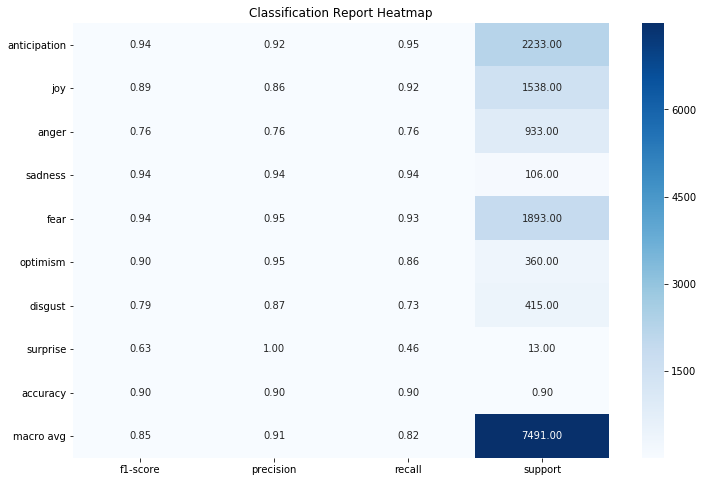

In [37]:
import seaborn as sns

report = classification_report(
    t_labels,
    predictions,
    target_names=[str(i) for i in data["emotion"].unique()],
    output_dict=True,
)
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()


In [126]:
text1 = "i don't like you"
text2 = "it's my birthday."
text3 = "mangoes are nasty."
text4 = "she fell down and hit her head. It made her cry"
doc = nlp(text4)

doc.cats
predicted_category = max(doc.cats, key=doc.cats.get)
print(f"predicted emotion: {predicted_category}")


predicted emotion: sadness
